In [40]:
# By Robert Onuma
# This program uses Neural Networks to identify uptrends and down trends (based on 30 pip differences) in
#financial markets.
# I made sure the parameters for the NN model were reduced and the example data frame was short as well
#to make sure that the program was more computationally friendly to anyone running it. However, it did 
#drastically reduce the accuracy of the test data as a result.
import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier


In [41]:
def clean_NA(df1):
    df1.reset_index(drop=True, inplace=True)
    df1.isna().sum()
    #df1.tail()
    return df1

In [42]:
def add_bolinger(df1):
    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=df1["close"], window=20, window_dev=2)

    # Add Bollinger Bands features
    df1['bb_bbm'] = indicator_bb.bollinger_mavg()
    df1['bb_bbh'] = indicator_bb.bollinger_hband()
    df1['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Bollinger Band high indicator
    df1['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    df1['bb_bbli'] = indicator_bb.bollinger_lband_indicator()
    
    #df1[df1['bb_bbli']==1]
    return df1

In [43]:
def add_rsi(df1):
    indicator_rsi = RSIIndicator(close=df1["close"], window=14)
    df1['rsi'] = indicator_rsi.rsi()
    return df1

In [44]:

def my_target(df1, df_len):
    pipdiff = 0.00300
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    j = 0
    for i in range(df_len):
        j = i+1
        continue_flag = True
        trendcat[i] = 0
        #print(close[i] - pipdiff)
        
        while j < df_len and continue_flag == True:
            #print(high[j])
            
            if low[j] < close[i] - pipdiff and high[j] < close[i] + pipdiff:
                trendcat[i] = 1 #downtrend
                continue_flag = False
            elif low[j] > close[i] - pipdiff and high[j] > close[i] + pipdiff:
                trendcat[i] = 2 #uptrend
                continue_flag = False
            else:
                trendcat[i] = 0 #no clear trend
            j=j+1
        #print()
        #print()
    return trendcat

In [45]:
def extract_time(df1, df_len):
    time_col = [None] * df_len
    for i in range(df_len):
        split_date = df1['date'][i].split(' ')
        time_col[i] = split_date[1]
    df1['time'] = time_col
    #df1.head()
    return df1

In [46]:
def filter_time(df1, df2, df_len):
    for i in range(df_len):
        if df1['time'][i] < '09:00:00' or df1['time'][i] > '18:00:00':
            df2 = df2.drop([i], axis=0)
        
    return df2

In [47]:
def weak_classifier(df1):
    attributes = ['rsi', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli']
    X = df1[attributes]
    y = df1['Target']

    train_pct_index = int(0.7 * len(X))
    X_train, X_test = X[:train_pct_index], X[train_pct_index:]
    y_train, y_test = y[:train_pct_index], y[train_pct_index:]

    model = XGBClassifier()
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    print('****Train Results****')
    print("Accuracy: {:.4%}".format(acc_train))
    print('****Test Results****')
    print("Accuracy: {:.4%}".format(acc_test))
    
    matrix_train = confusion_matrix(y_train, pred_train)
    matrix_test = confusion_matrix(y_test, pred_test)

    print(matrix_train)
    print(matrix_test)

    report_train = classification_report(y_train, pred_train)
    report_test = classification_report(y_test, pred_test)

    print(report_train)
    print(report_test)
    #choices = [2, 0, -1, +1]
    ##choices = [2, 0, 3, +1]
    print(model.get_booster().feature_names)
    
    #pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
    #plot feature importance
    plot_importance(model)
    pyplot.show()
    print(model.get_booster().feature_names)
    
    return model
    

In [54]:
def NN_model(df1):
    attributes = ['rsi', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli']
    X = df1[attributes]
    y = df1['Target']

    train_pct_index = int(0.7 * len(X))
    X_train, X_test = X[:train_pct_index], X[train_pct_index:]
    y_train, y_test = y[:train_pct_index], y[train_pct_index:]
    
    model = MLPClassifier(hidden_layer_sizes = (3, 3), max_iter=400)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    print('****Train Results****')
    print("Accuracy: {:.4%}".format(acc_train))
    print('****Test Results****')
    print("Accuracy: {:.4%}".format(acc_test))
    
    matrix_train = confusion_matrix(y_train, pred_train)
    matrix_test = confusion_matrix(y_test, pred_test)

    print(matrix_train)
    print(matrix_test)

    report_train = classification_report(y_train, pred_train)
    report_test = classification_report(y_test, pred_test)

    print(report_train)
    print(report_test)
    
    return model

In [55]:
def main():
    df = pd.read_csv("EURUSD_2023-01-30-00_00.csv")
    df_len = len(df)
    df = clean_NA(df)
    df = add_bolinger(df)
    df = add_rsi(df)
    df['Target'] = my_target(df, df_len)
    df['Target'].hist()
    df = extract_time(df, df_len)
    
    df_trade_time = df.copy()
    df_trade_time = filter_time(df, df_trade_time, df_len)
    
    df_train_data = df_trade_time[:722]
    
    model = NN_model(df_train_data)
    

****Train Results****
Accuracy: 97.6238%
****Test Results****
Accuracy: 16.5899%
[[493   0]
 [ 12   0]]
[[ 36   0]
 [181   0]]
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       493
           2       0.00      0.00      0.00        12

    accuracy                           0.98       505
   macro avg       0.49      0.50      0.49       505
weighted avg       0.95      0.98      0.96       505

              precision    recall  f1-score   support

           1       0.17      1.00      0.28        36
           2       0.00      0.00      0.00       181

    accuracy                           0.17       217
   macro avg       0.08      0.50      0.14       217
weighted avg       0.03      0.17      0.05       217



/Users/robertwillfindyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertwillfindyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertwillfindyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

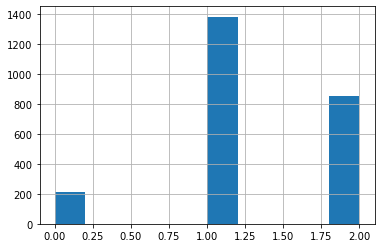

In [56]:
main()